<a href="https://colab.research.google.com/github/hana-dool/2021_Dacon_Classification/blob/master/Upsampling0119.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

- 시계열로 밀어붙이기에는 label 에 비해 상대적으로 너무 데이터가 적어서 학습하기가 힘들것 같다.
- 불균형 데이터의 Classification 으로 무언가 조치가 필요해 보인다.
- 각도의 경우 Cosine / sin 변환 요구됨
- Dropout 요구됨
- randomness 고정 요구됨
- 더욱 Upsampling 을 진행한 후에, relu 쌓아서 해야할거같다.

1. 한 개의 행은 0.02초 (second)를 의미합니다. 즉 하나의 id 에 대해서 600개의 time 이 존재하므로  총 12초(0.02*600)동안의 동작을 측정한 것입니다.

2. 이 때에 가속계와, 자이로스코프는 오른쪽 forearm(전완) 에 착용하여 측정한 데이터입니다.

3. 가속도계는 해당 방향으로의 가속도(g)를, 자이로스코프는 해당 방향으로의 dps(degrees per second)를 측정한 것입니다.


- 우선 가속도 방향은 항상 중력방향으로 작용한다. 그러므로 운동을 하지 않을 때에도 어느정도는 계속 측정이 되고있는 상태이다.
- 그렇다면 가속도의 합을 
- 가속도를 이용해서 각 각도 등을 측정 가능할 것이다. 

# **데이터 불러오기**

In [208]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
import os
os.chdir('/content/drive/MyDrive/2101_Dacon_Classification')

In [64]:
import pandas as pd
import numpy as np

train=pd.read_csv('data/train_features.csv')
train_labels=pd.read_csv('data/train_labels.csv')
test=pd.read_csv('data/test_features.csv')
submission=pd.read_csv('data/sample_submission.csv')

In [180]:
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.layers import GRU, LSTM

In [229]:
import warnings
warnings.filterwarnings('ignore')

# **데이터 살펴보기**

In [84]:
train

id  time     acc_x  ...       gy_x        gy_y       gy_z
0           0     0  1.206087  ...  -0.591608  -30.549010 -31.676112
1           0     1  1.287696  ...   0.303100  -39.139103 -24.927216
2           0     2  1.304609  ...  -3.617278  -44.122565 -25.019629
3           0     3  1.293095  ...   2.712986  -53.597843 -27.454013
4           0     4  1.300887  ...   4.286707  -57.906561 -27.961234
...       ...   ...       ...  ...        ...         ...        ...
1874995  3124   595 -0.712530  ... -29.367857 -104.013664 -76.290437
1874996  3124   596 -0.683037  ... -30.149089 -101.796809 -76.625087
1874997  3124   597 -0.664730  ... -27.873095  -98.776072 -79.365125
1874998  3124   598 -0.630534  ... -23.636550  -99.139495 -80.259478
1874999  3124   599 -0.578351  ... -17.917626 -100.181873 -80.676229

[1875000 rows x 8 columns]

In [91]:
train

id  time     acc_x  ...       gy_x        gy_y       gy_z
0           0     0  1.206087  ...  -0.591608  -30.549010 -31.676112
1           0     1  1.287696  ...   0.303100  -39.139103 -24.927216
2           0     2  1.304609  ...  -3.617278  -44.122565 -25.019629
3           0     3  1.293095  ...   2.712986  -53.597843 -27.454013
4           0     4  1.300887  ...   4.286707  -57.906561 -27.961234
...       ...   ...       ...  ...        ...         ...        ...
1874995  3124   595 -0.712530  ... -29.367857 -104.013664 -76.290437
1874996  3124   596 -0.683037  ... -30.149089 -101.796809 -76.625087
1874997  3124   597 -0.664730  ... -27.873095  -98.776072 -79.365125
1874998  3124   598 -0.630534  ... -23.636550  -99.139495 -80.259478
1874999  3124   599 -0.578351  ... -17.917626 -100.181873 -80.676229

[1875000 rows x 8 columns]

In [103]:
import matplotlib.pyplot as plt

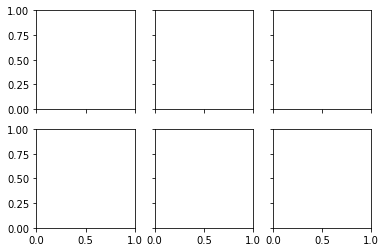

In [104]:
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
ax

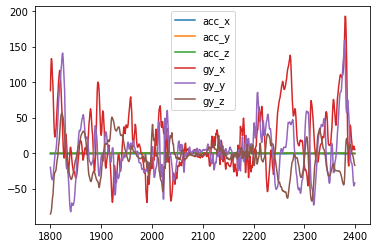

In [105]:
train[train['id']==3].iloc[:,2:].plot()

In [121]:
import random

In [140]:
train_labels['label_desc'].unique()

array(['Shoulder Press (dumbbell)', 'Non-Exercise', 'Biceps Curl (band)',
       'Side Plank Right side', 'Plank', 'Chest Press (rack)',
       'Wall Squat', 'Russian Twist', 'Running (treadmill)',
       'Pushup (knee or foot variation)', 'Wall Ball',
       'Dynamic Stretch (at your own pace)',
       'Sit-up (hands positioned behind head)', 'Tap Right Device',
       'Static Stretch (at your own pace)', 'Device on Table',
       'Triceps extension (lying down)', 'Elliptical machine', 'Burpee',
       'Walking lunge', 'Lateral Raise', 'Jump Rope',
       'Triceps Kickback (knee on bench) (label spans both arms)',
       'Medicine Ball Slam',
       'Lunge (alternating both legs, weight optional)',
       'Fast Alternating Punches', 'Static stretch',
       'Squat Rack Shoulder Press', 'Overhead Triceps Extension',
       'Seated Back Fly', 'Bicep Curl', 'Side Plank Left side',
       'Dumbbell Squat (hands at side)', 'Dumbbell Deadlift Row',
       'Two-arm Dumbbell Curl (both arms, 

In [153]:
train.columns[2:]

Index(['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [ ]:
        plt.subplot(6,2,2*i+1)
        idx = random.choice(list(train_labels[train_labels[exercise] == 'V-up']['id']))
        plt.plot(train[train['id']==idx].iloc[:,2:5])
        plt.legend(train.columns[2:5])
        plt.subplot(6,2,2*i+2)
        plt.plot(train[train['id']==idx].iloc[:,5:])
        plt.legend(train.columns[5:])

In [226]:
def plot(exercise) : 
    plt.figure(figsize= (25,15))
    plt.subplots_adjust(top = 1.3)
    for i in range(0,1) :
        plt.subplot(6,2,2*i+1)
        idx = random.choice(list(train_labels[train_labels['label_desc'] == exercise ]['id']))
        plt.plot(train[train['id']==idx].iloc[:,2:5])
        plt.legend(train.columns[2:5])
        plt.title(exercise)
        plt.subplot(6,2,2*i+2)
        plt.plot(train[train['id']==idx].iloc[:,5:])
        plt.legend(train.columns[5:])
        plt.title(exercise)

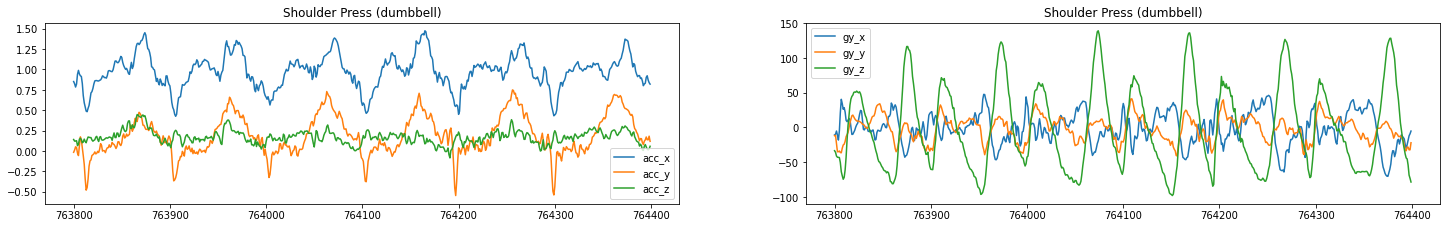

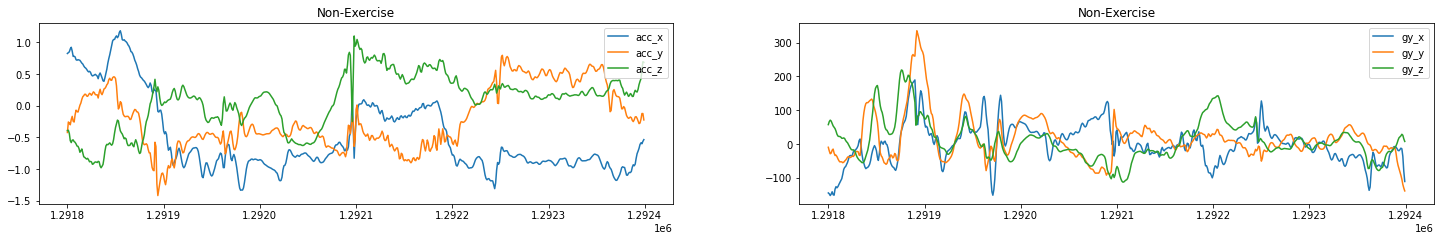

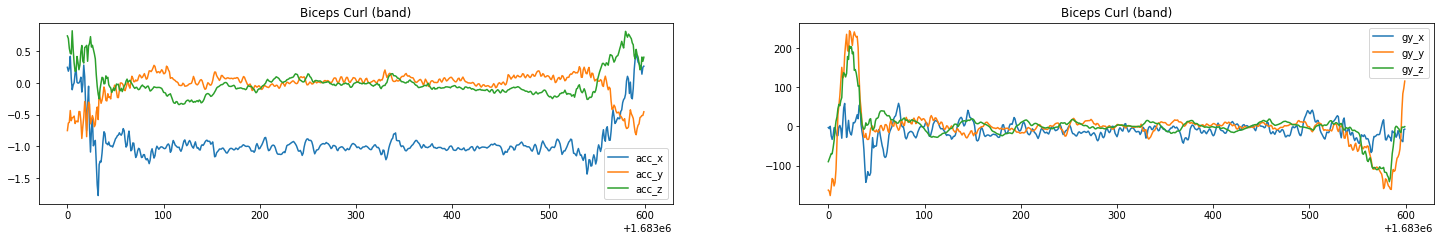

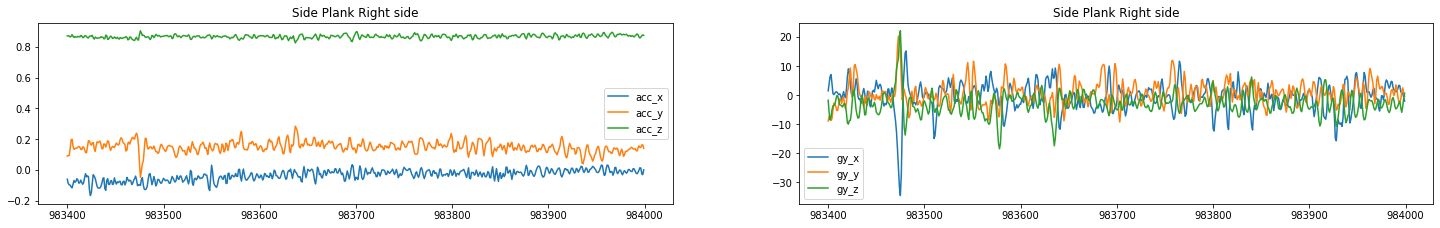

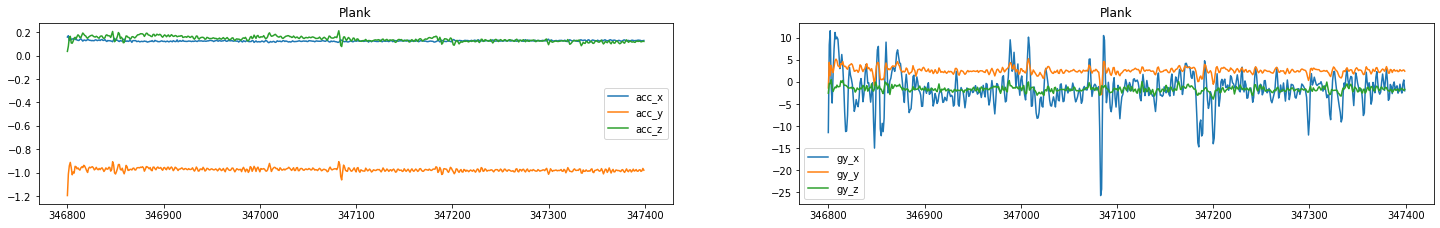

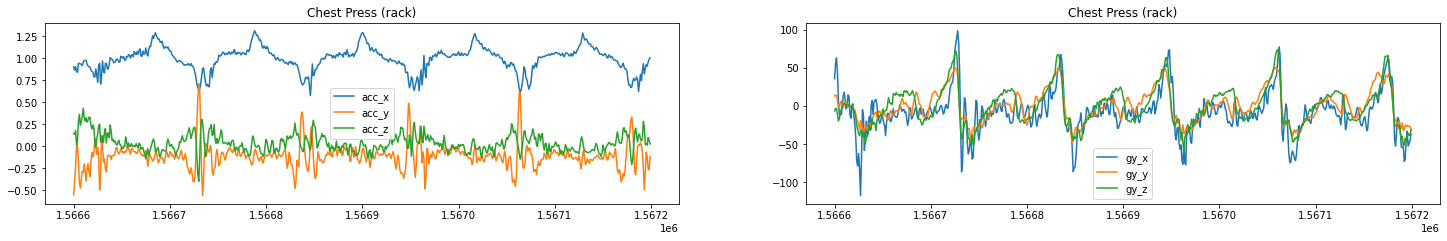

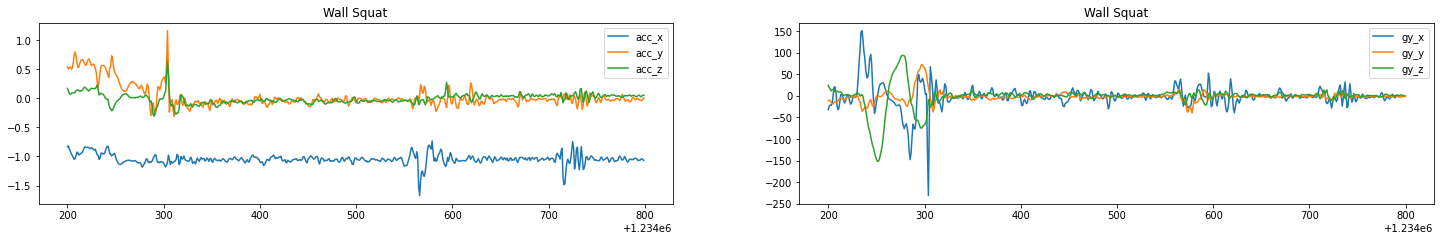

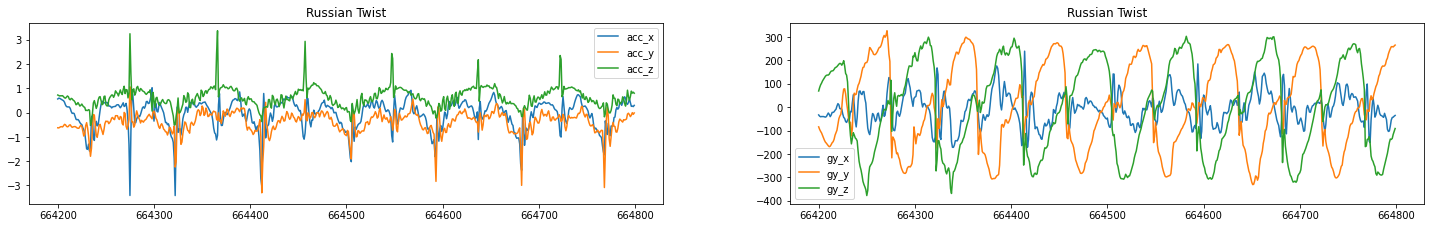

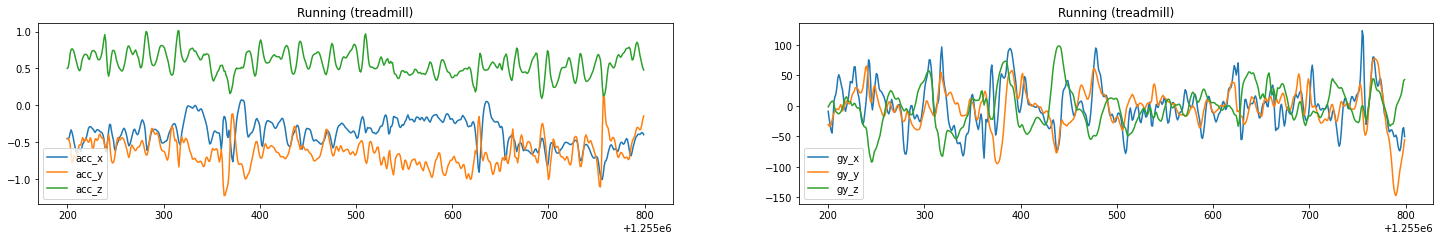

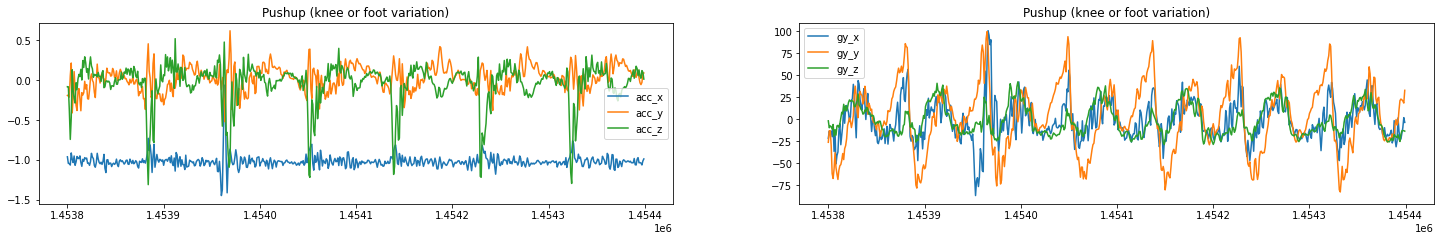

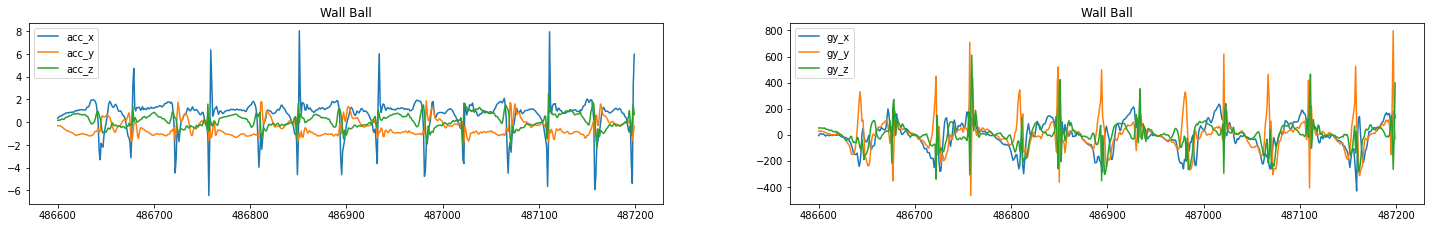

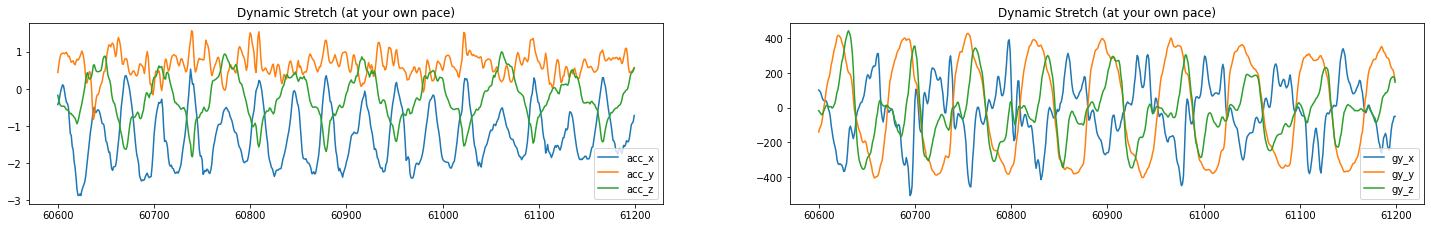

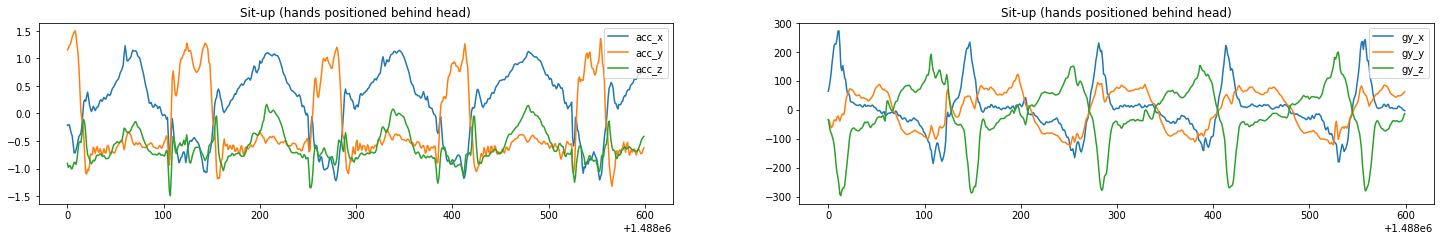

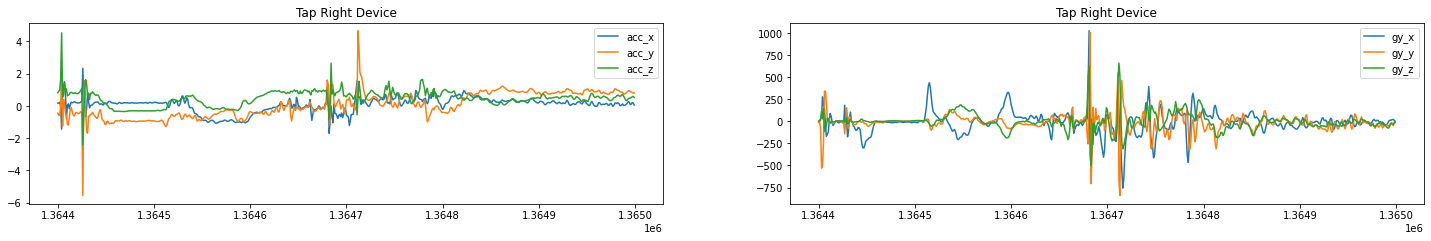

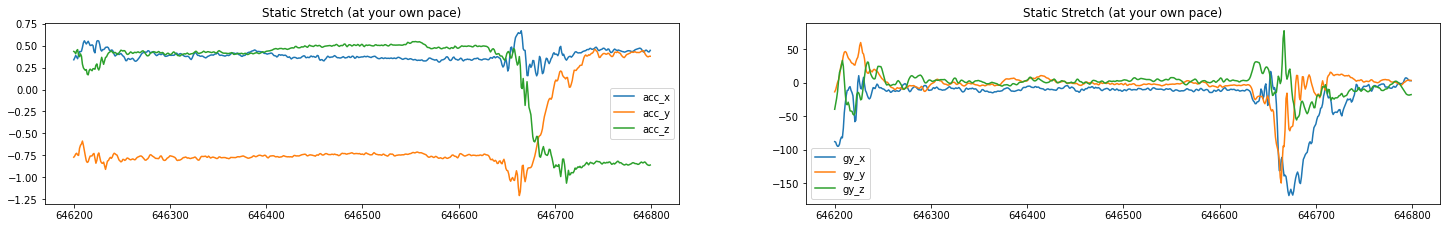

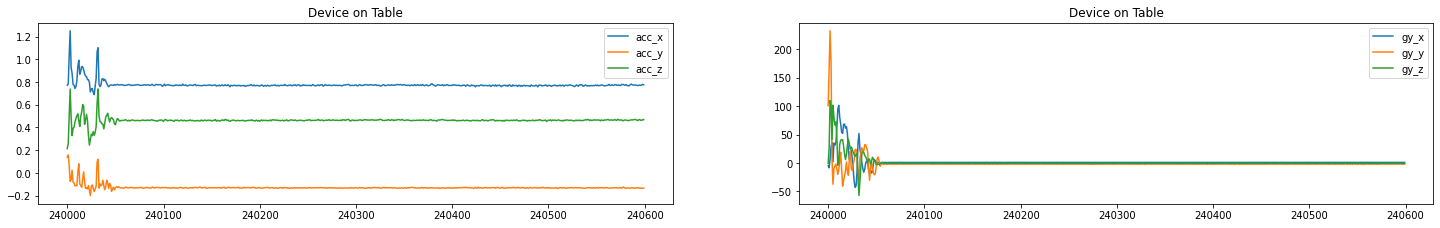

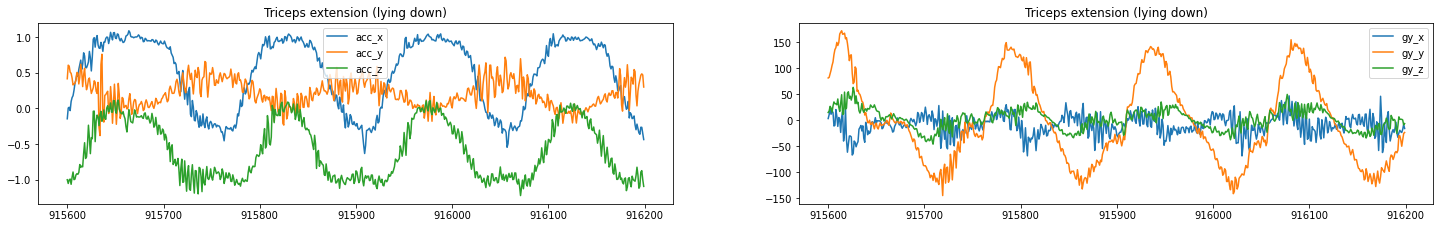

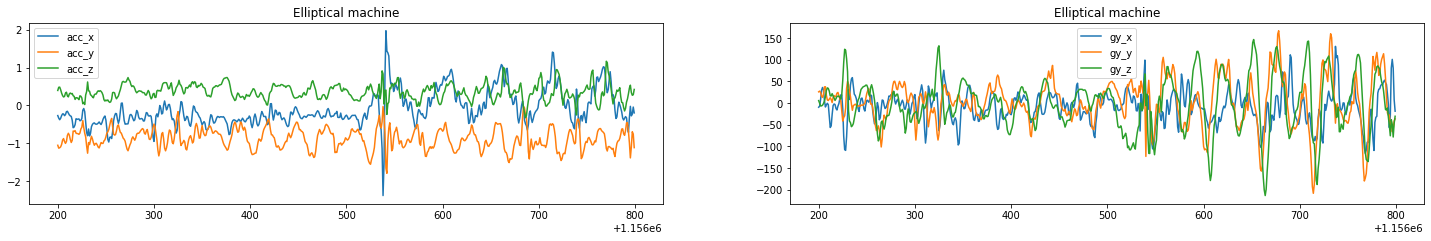

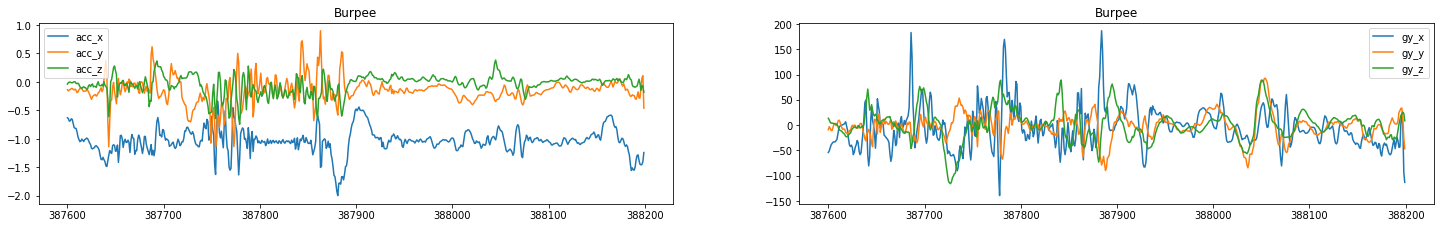

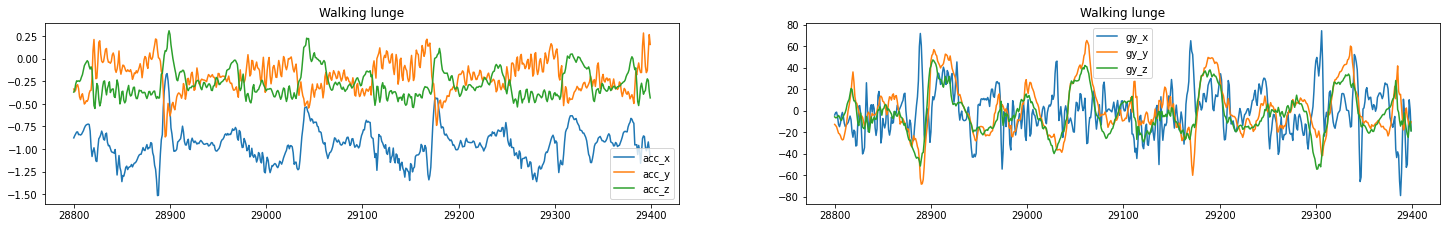

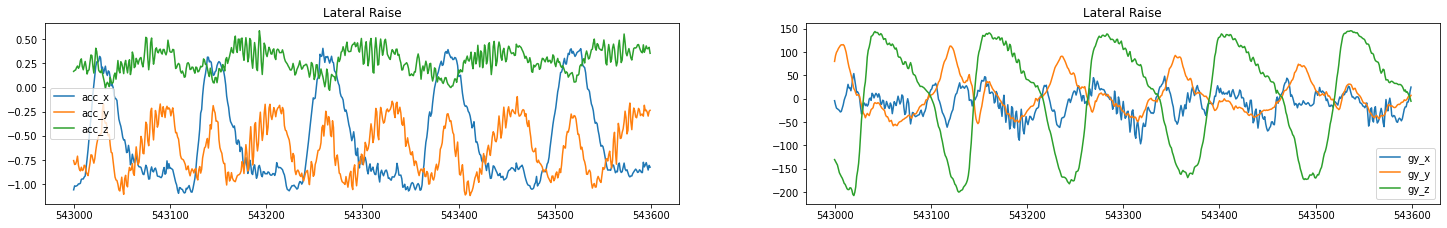

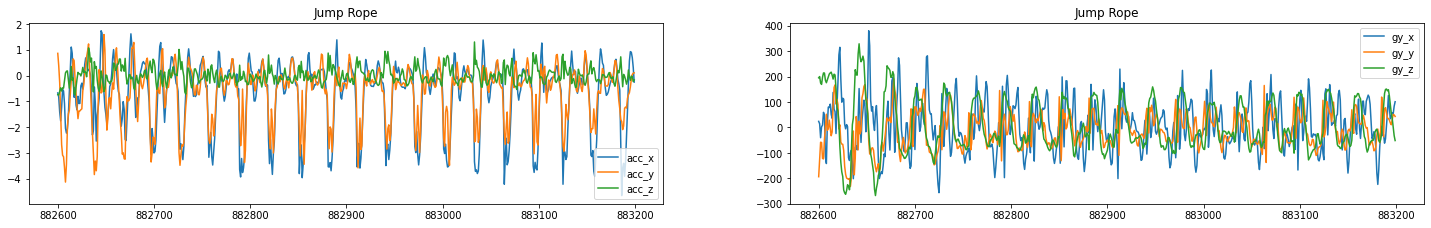

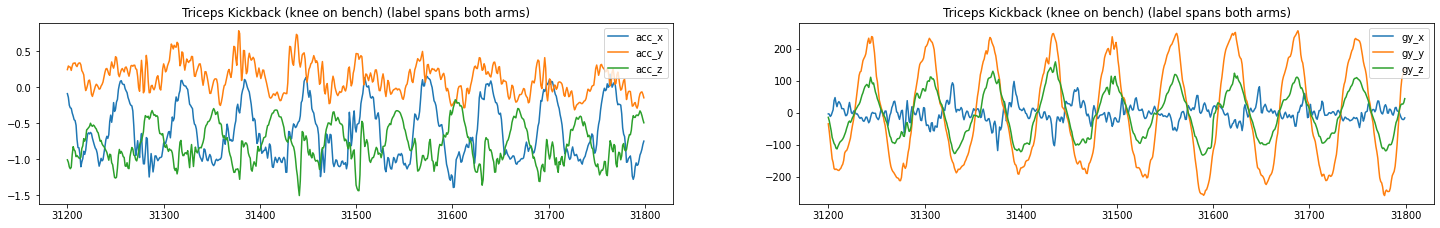

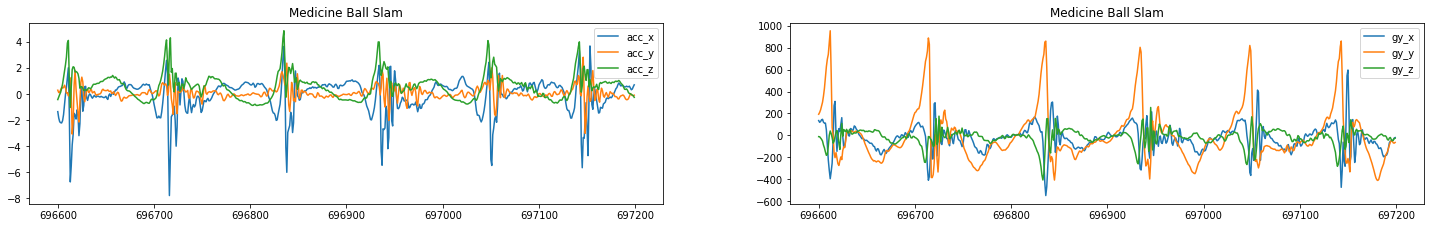

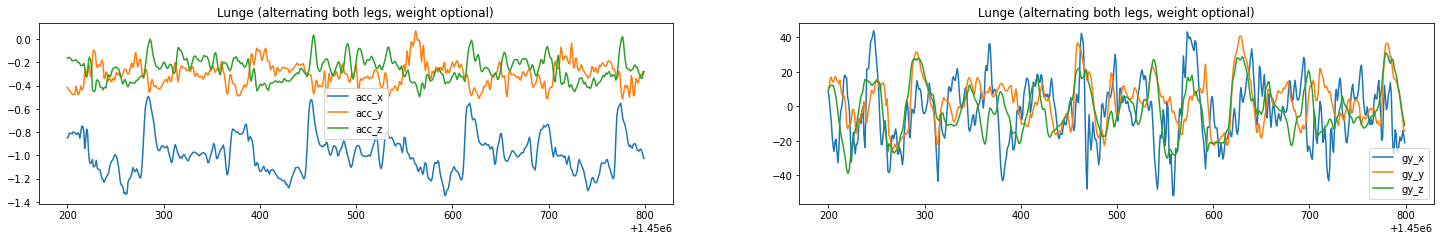

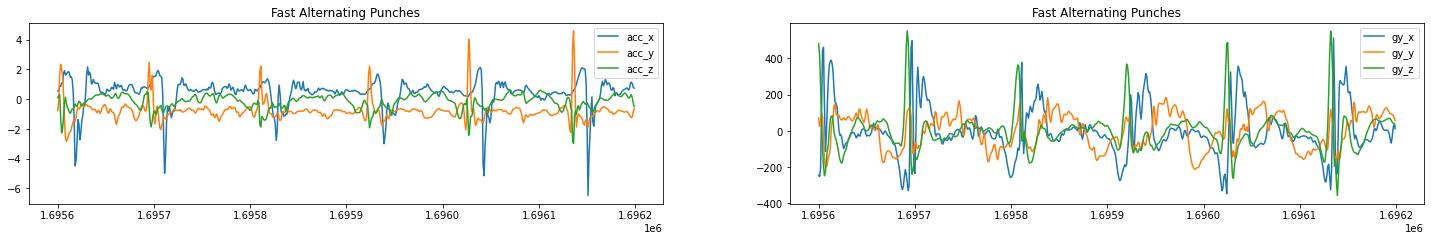

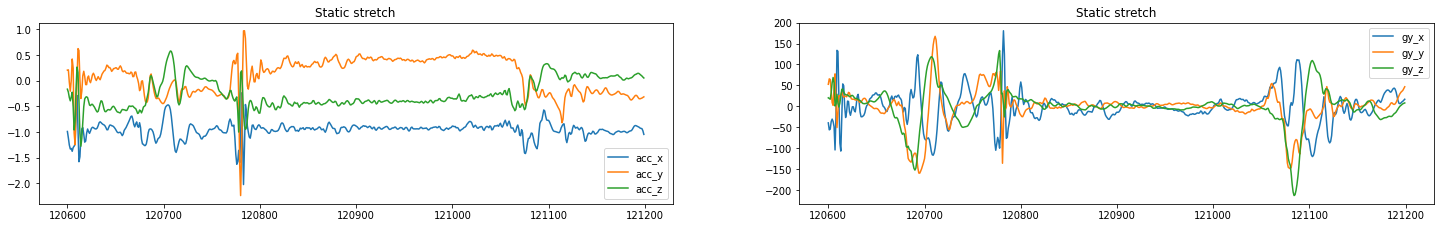

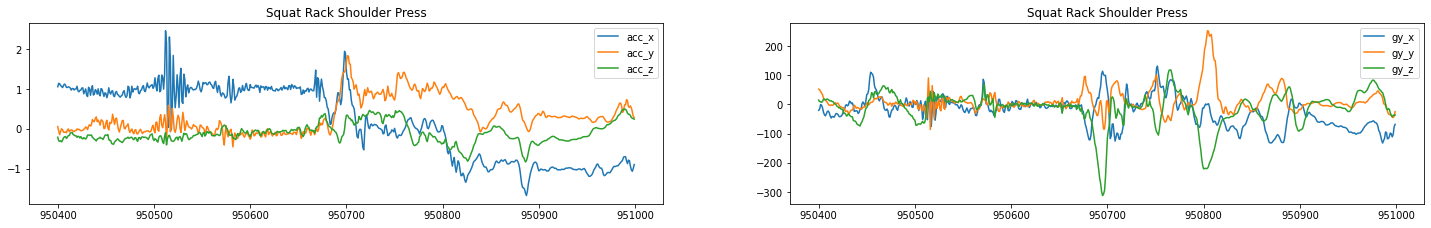

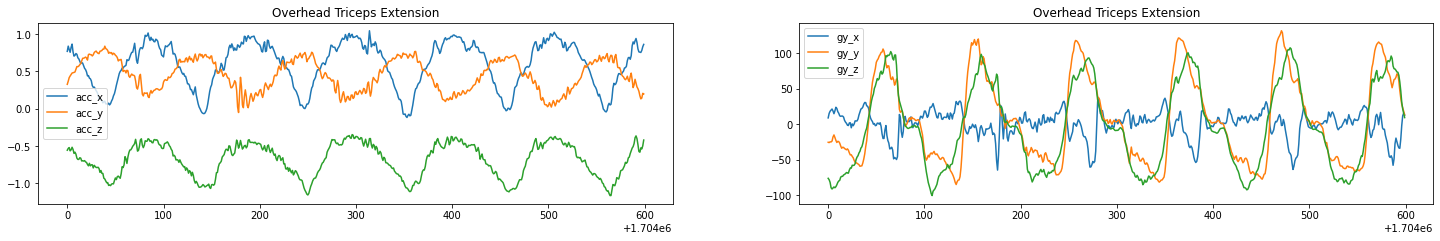

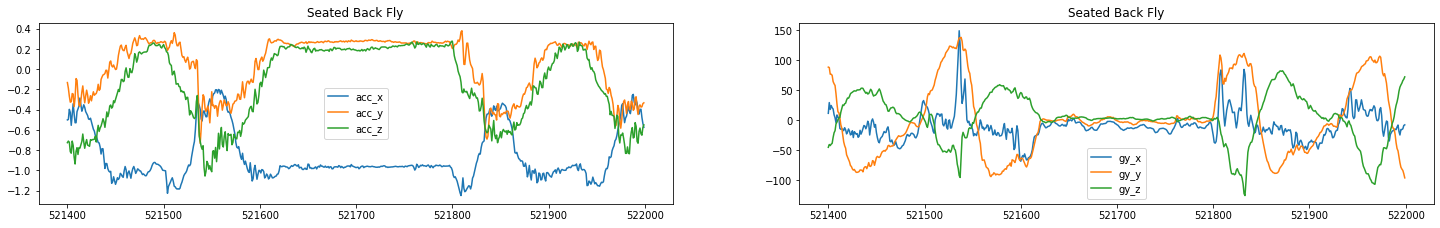

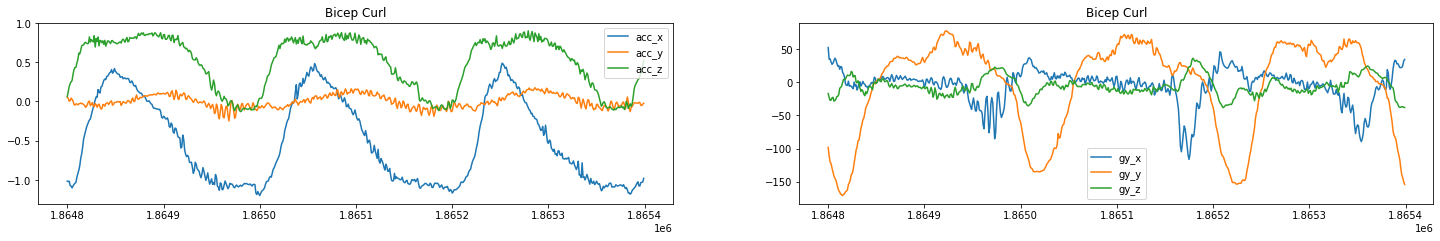

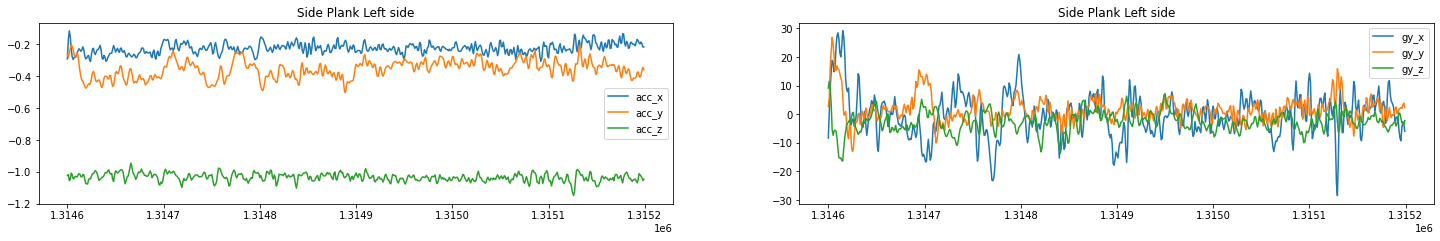

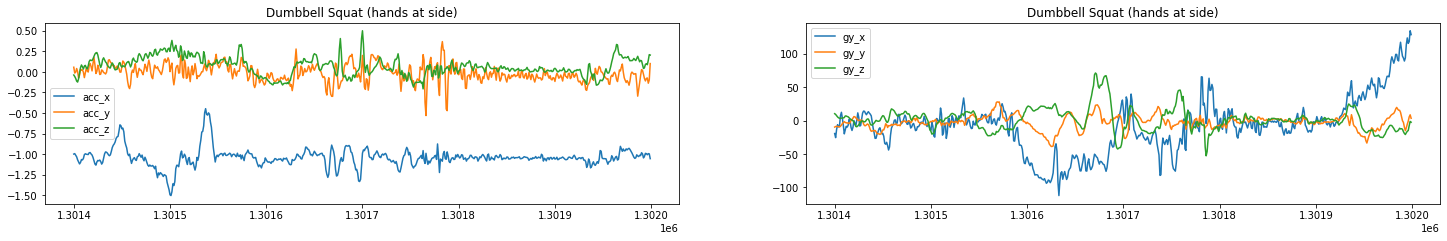

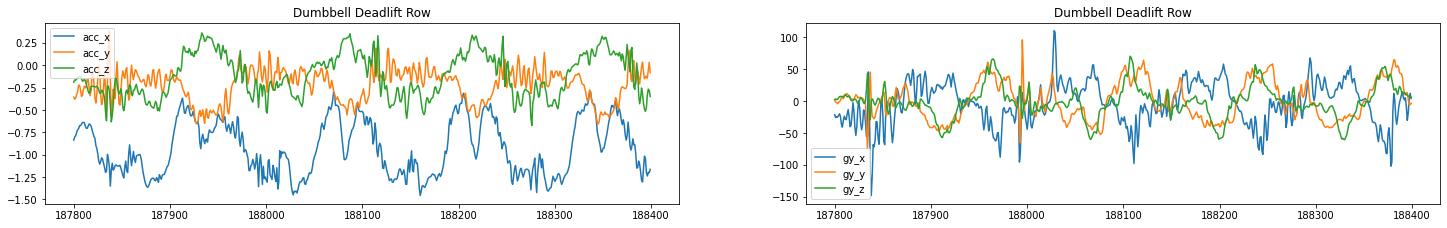

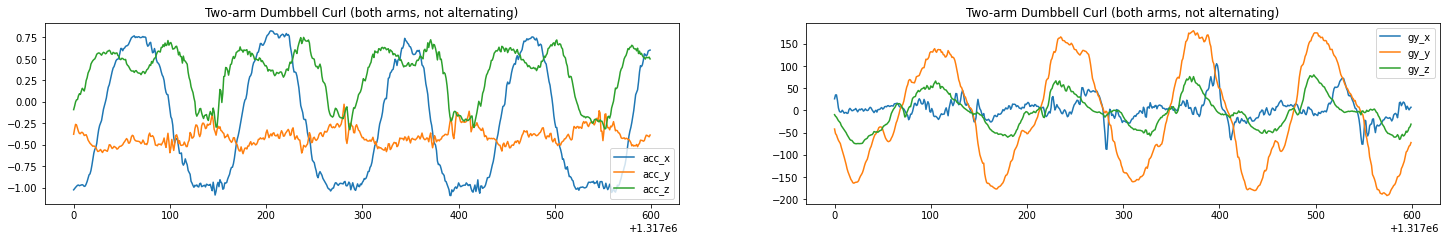

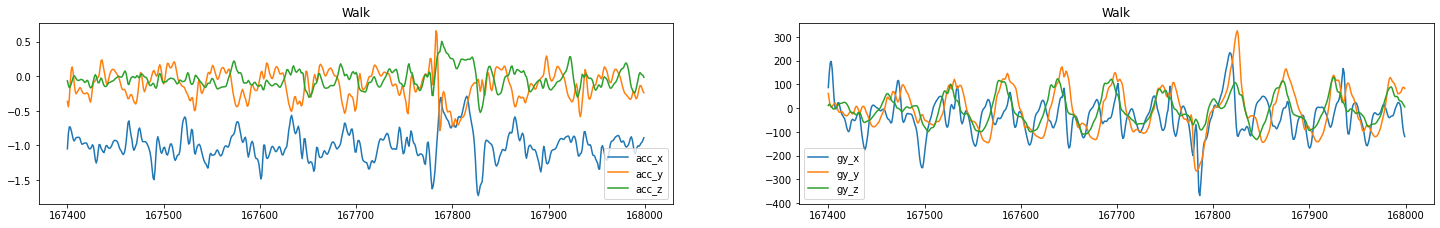

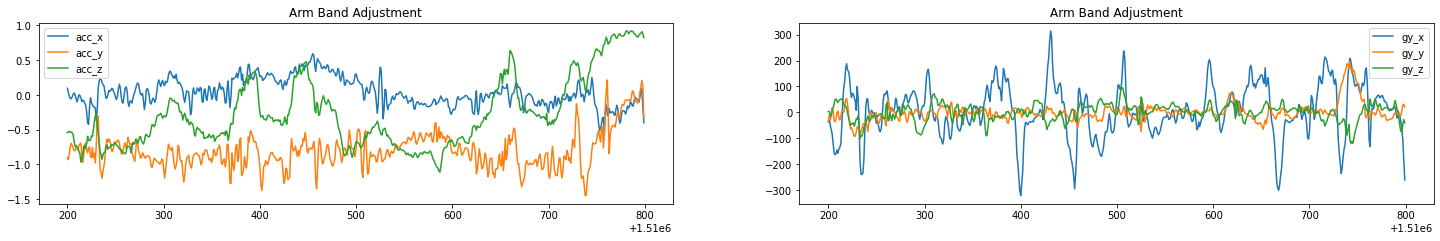

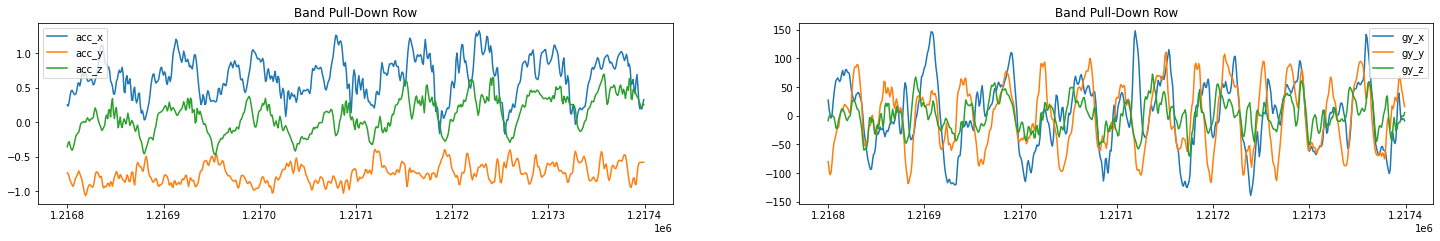

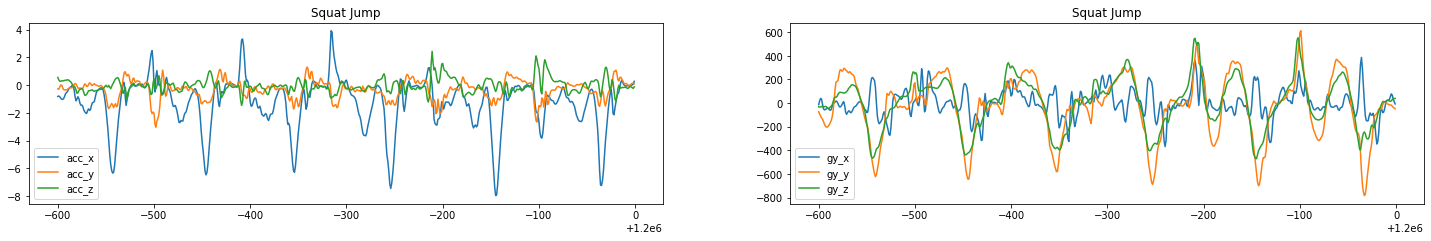

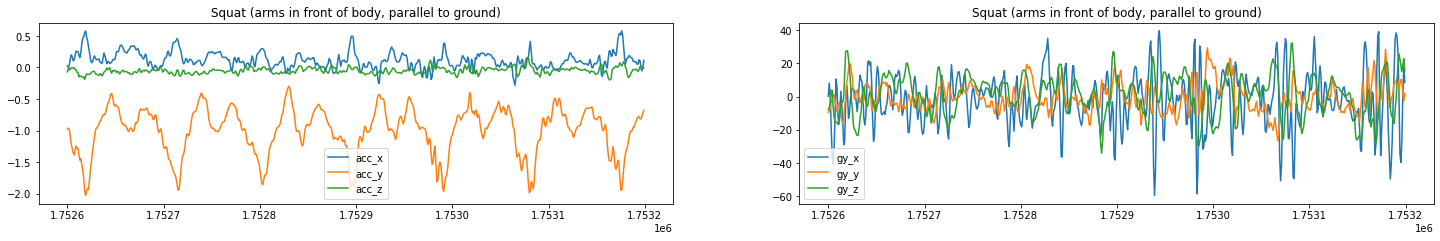

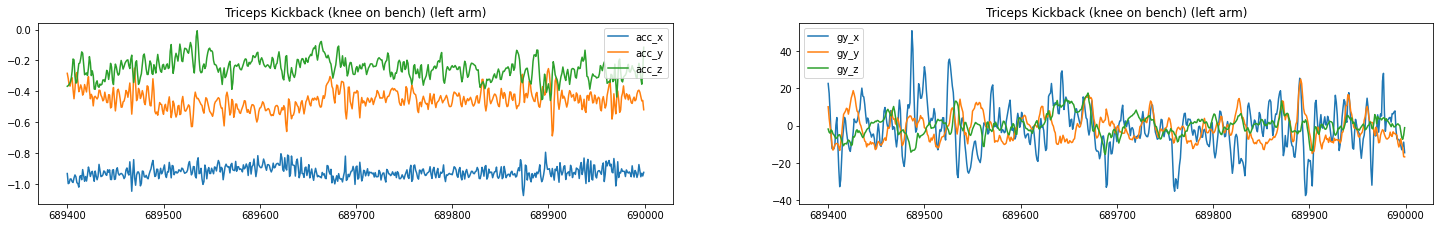

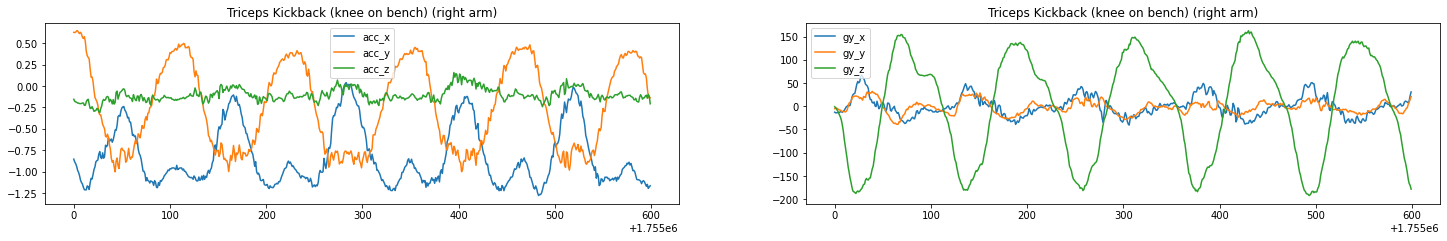

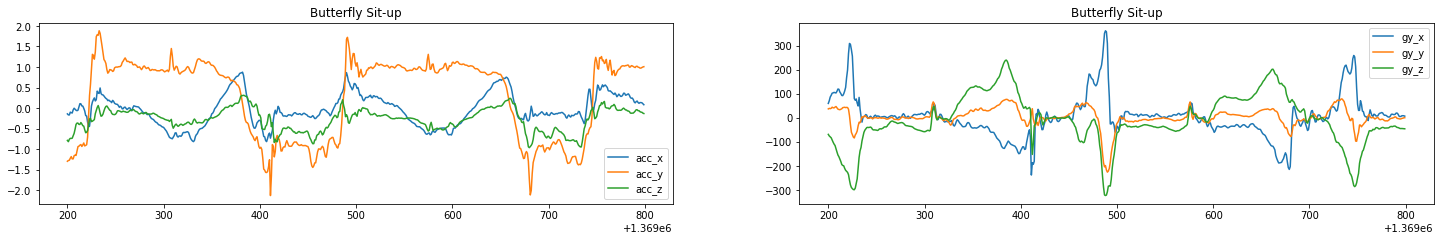

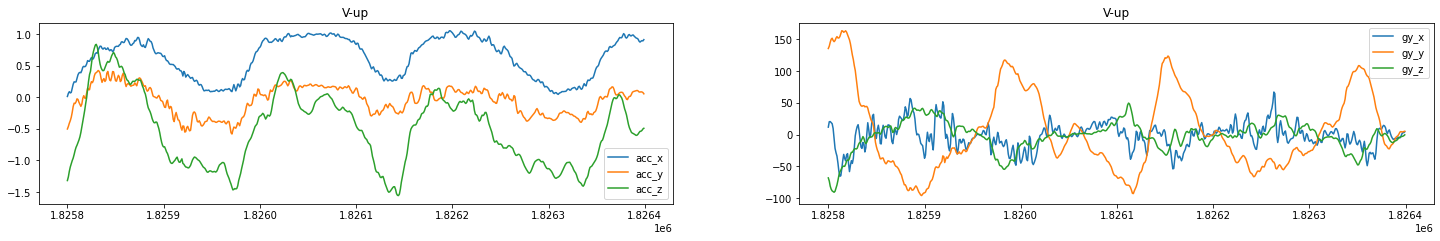

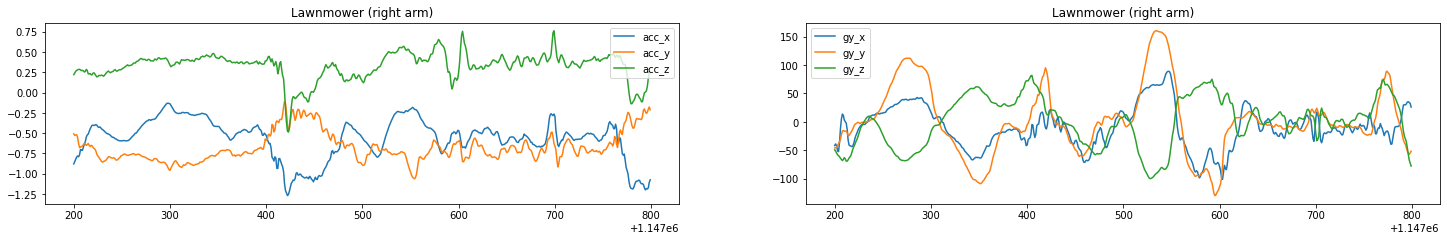

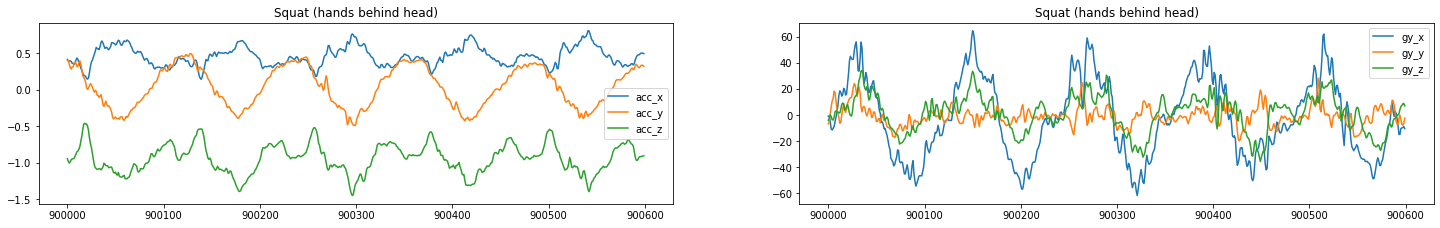

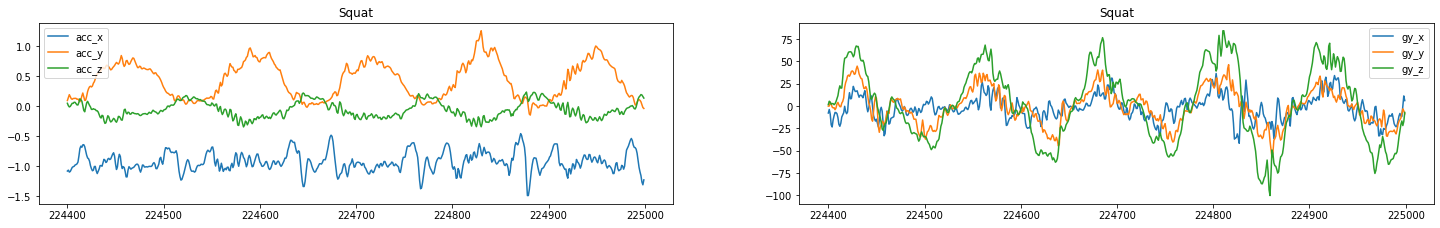

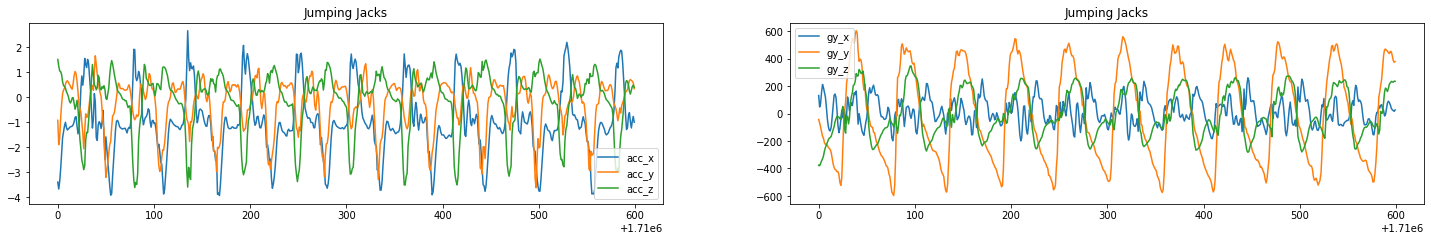

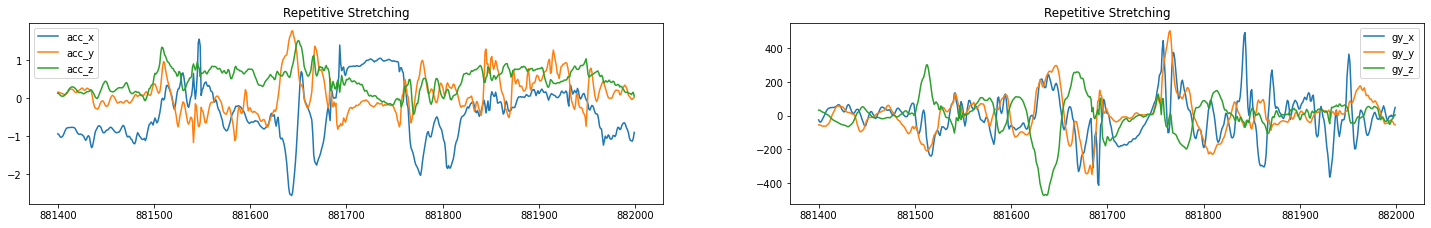

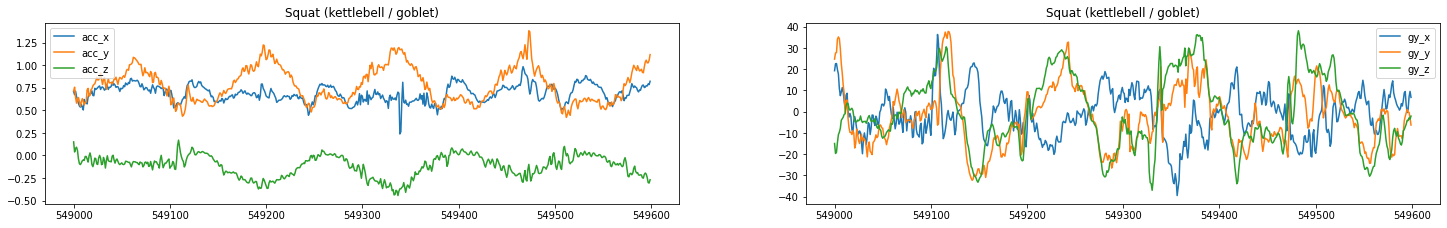

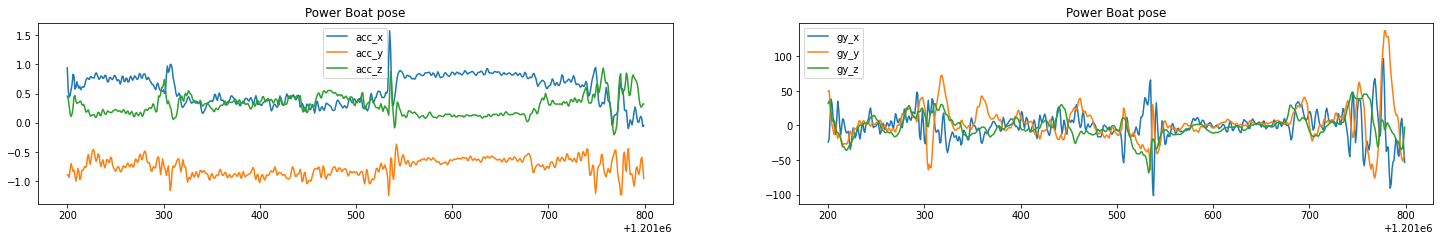

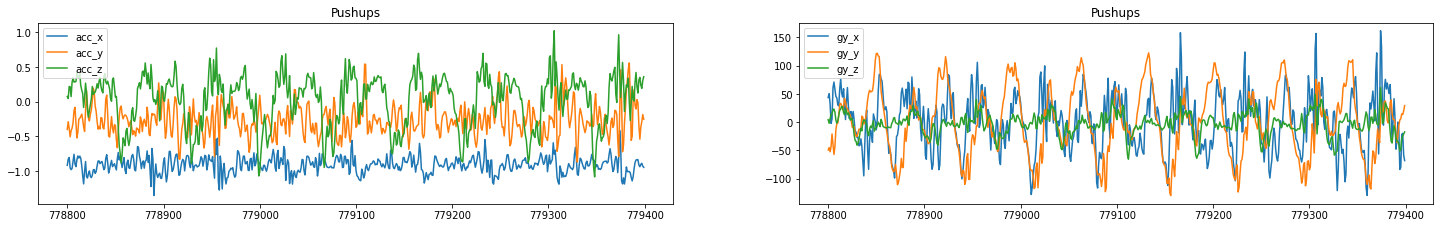

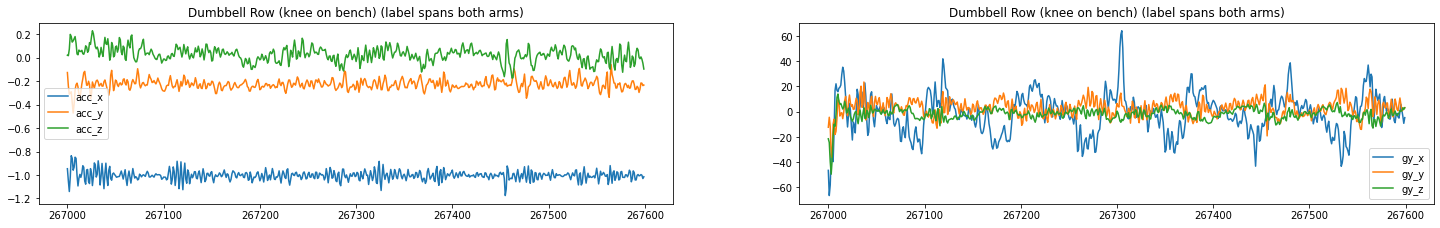

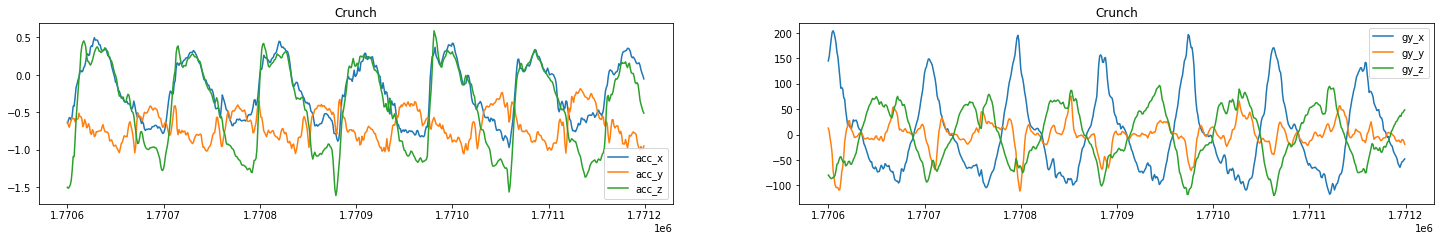

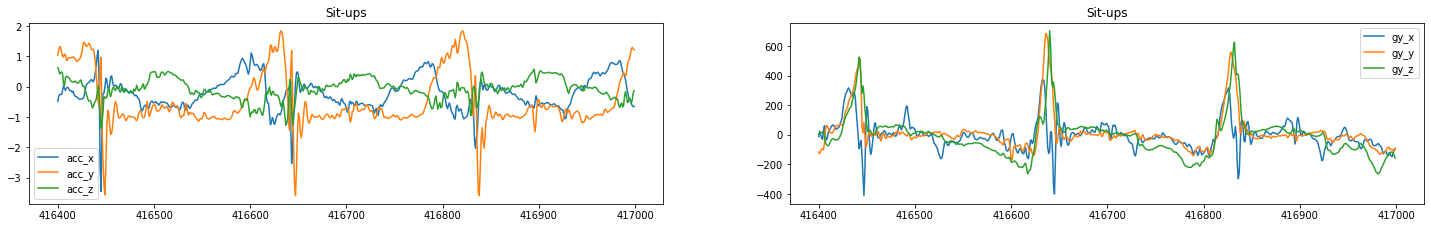

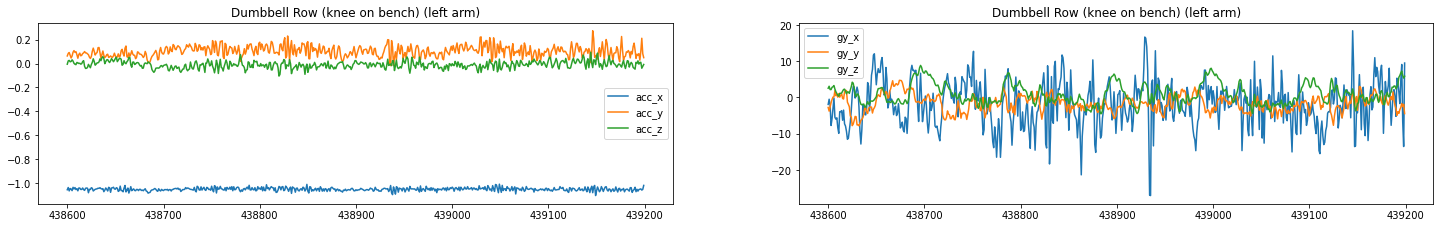

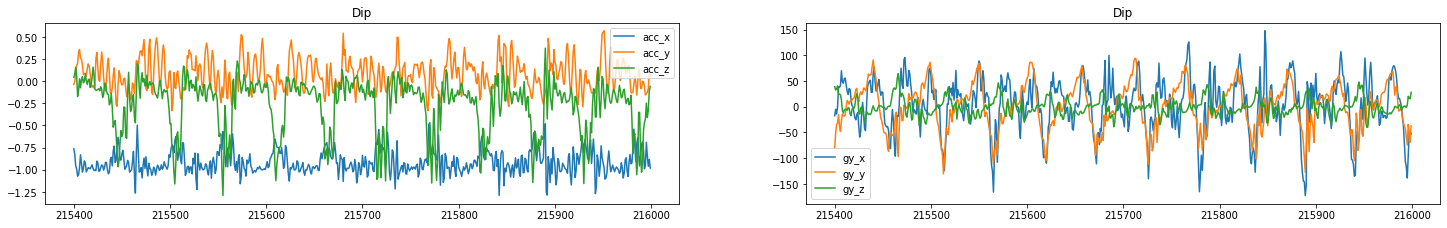

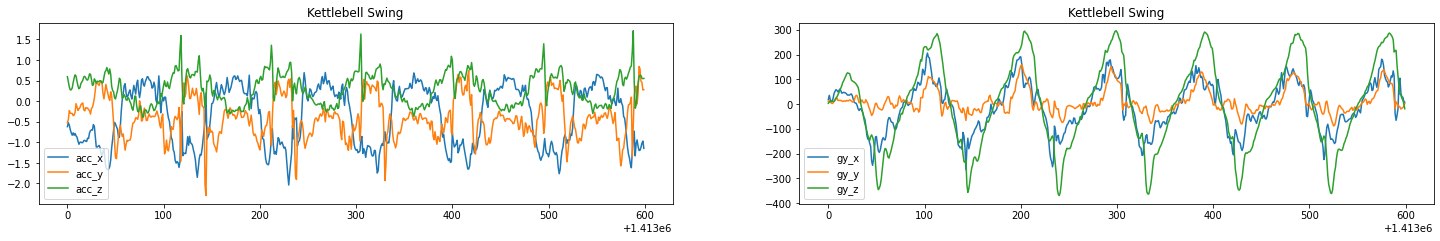

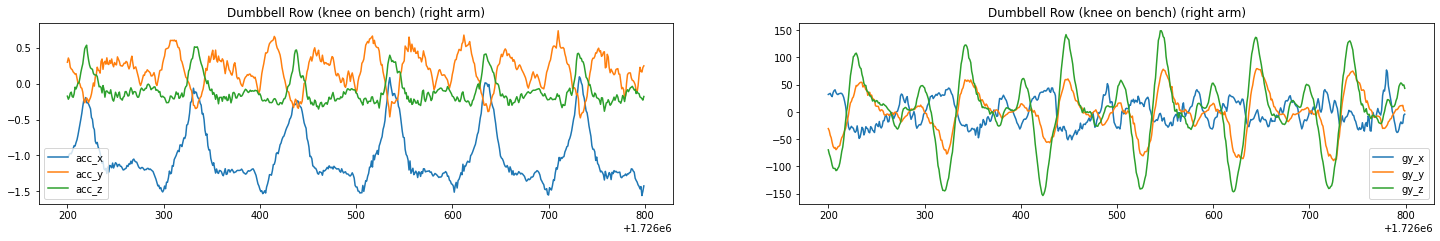

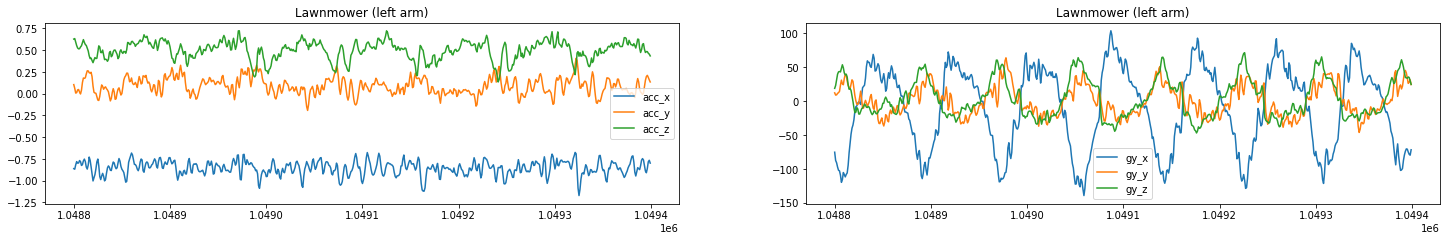

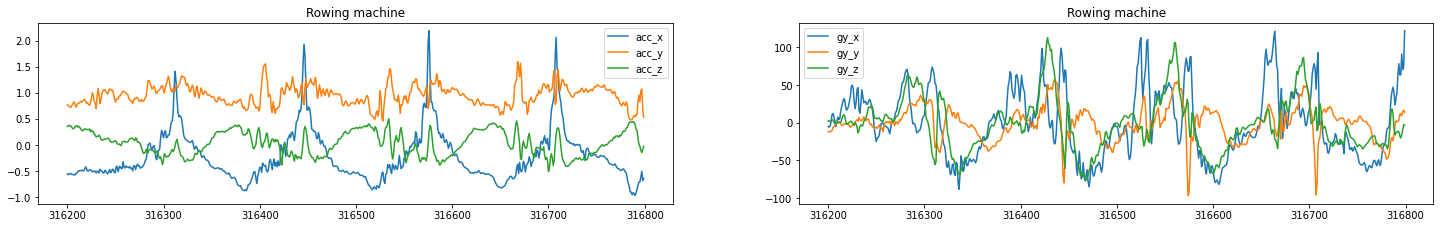

In [230]:
for i in train_labels['label_desc'].unique() :
    plot(i)

In [231]:
train

id  time     acc_x  ...       gy_x        gy_y       gy_z
0           0     0  1.206087  ...  -0.591608  -30.549010 -31.676112
1           0     1  1.287696  ...   0.303100  -39.139103 -24.927216
2           0     2  1.304609  ...  -3.617278  -44.122565 -25.019629
3           0     3  1.293095  ...   2.712986  -53.597843 -27.454013
4           0     4  1.300887  ...   4.286707  -57.906561 -27.961234
...       ...   ...       ...  ...        ...         ...        ...
1874995  3124   595 -0.712530  ... -29.367857 -104.013664 -76.290437
1874996  3124   596 -0.683037  ... -30.149089 -101.796809 -76.625087
1874997  3124   597 -0.664730  ... -27.873095  -98.776072 -79.365125
1874998  3124   598 -0.630534  ... -23.636550  -99.139495 -80.259478
1874999  3124   599 -0.578351  ... -17.917626 -100.181873 -80.676229

[1875000 rows x 8 columns]

In [6]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

In [198]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
# 아 이거 너~ 무 불균형인데?
# Validation 이... 지금 그냥 다 0.5
train_labels['label_desc'].value_counts()

Non-Exercise                                    1518
Device on Table                                   97
Plank                                             55
Wall Squat                                        48
Jump Rope                                         47
                                                ... 
Triceps Kickback (knee on bench) (right arm)      13
Arm Band Adjustment                               12
Dumbbell Row (knee on bench) (left arm)           12
Triceps Kickback (knee on bench) (left arm)       12
Dumbbell Row (knee on bench) (right arm)          12
Name: label_desc, Length: 61, dtype: int64

In [199]:
train_labels

id  label                          label_desc
0        0     37           Shoulder Press (dumbbell)
1        1     26                        Non-Exercise
2        2      3                  Biceps Curl (band)
3        3     26                        Non-Exercise
4        4     26                        Non-Exercise
...    ...    ...                                 ...
3120  3120     26                        Non-Exercise
3121  3121     26                        Non-Exercise
3122  3122     15  Dynamic Stretch (at your own pace)
3123  3123     26                        Non-Exercise
3124  3124      2                          Bicep Curl

[3125 rows x 3 columns]

In [12]:
#test'id'는 782개 
test['id'].nunique()

782

In [13]:
#782개의 id 별 동작 데이터를 활용해 각각의id가 어떤 동작인지를 분류하는 문제!!
submission

id  0  1  2  3  4  5  6  7  8  ...  51  52  53  54  55  56  57  58  59  60
0    3125  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
1    3126  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
2    3127  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
3    3128  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
4    3129  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
..    ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
777  3902  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
778  3903  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
779  3904  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
780  3905  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
781  3906  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0

[782 rows x 62 columns]

In [237]:
train

id  time     acc_x  ...       gy_x        gy_y       gy_z
0           0     0  1.206087  ...  -0.591608  -30.549010 -31.676112
1           0     1  1.287696  ...   0.303100  -39.139103 -24.927216
2           0     2  1.304609  ...  -3.617278  -44.122565 -25.019629
3           0     3  1.293095  ...   2.712986  -53.597843 -27.454013
4           0     4  1.300887  ...   4.286707  -57.906561 -27.961234
...       ...   ...       ...  ...        ...         ...        ...
1874995  3124   595 -0.712530  ... -29.367857 -104.013664 -76.290437
1874996  3124   596 -0.683037  ... -30.149089 -101.796809 -76.625087
1874997  3124   597 -0.664730  ... -27.873095  -98.776072 -79.365125
1874998  3124   598 -0.630534  ... -23.636550  -99.139495 -80.259478
1874999  3124   599 -0.578351  ... -17.917626 -100.181873 -80.676229

[1875000 rows x 8 columns]

In [239]:
train[['abs_acc_x','abs_acc_y','aba_acc_z','abs_gy_x','abs_gy_y','abs_gy_z']] = np.abs(train.iloc[:,2:])

# **라이브러리 불러오기**

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

# **데이터 수정**

In [240]:
X=tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 12])
X.shape

TensorShape([3125, 600, 12])

In [241]:
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

(3125, 61)

# Modeling

## LSTM (Baseline)

In [242]:
model1 = Sequential()
model1.add(LSTM(64, input_shape=(600,12)))
model1.add(Dense(61, activation='softmax'))
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=16, #16을 줘보자.
                                             restore_best_weights=True)
history1 = model1.fit(X, y, 
                        epochs=120,
                     batch_size = 16,
                        validation_split=0.2,
                        callbacks=[early_stopping])

Epoch 1/120
157/157 [==============================] - 5s 24ms/step - loss: 3.3499 - accuracy: 0.3442 - val_loss: 2.5746 - val_accuracy: 0.5104
Epoch 2/120
157/157 [==============================] - 3s 22ms/step - loss: 2.5071 - accuracy: 0.5012 - val_loss: 2.4848 - val_accuracy: 0.5056
Epoch 3/120
157/157 [==============================] - 3s 22ms/step - loss: 2.3558 - accuracy: 0.5078 - val_loss: 2.3740 - val_accuracy: 0.5200
Epoch 4/120
157/157 [==============================] - 3s 22ms/step - loss: 2.3401 - accuracy: 0.4834 - val_loss: 2.2666 - val_accuracy: 0.5248
Epoch 5/120
157/157 [==============================] - 3s 22ms/step - loss: 2.1372 - accuracy: 0.5109 - val_loss: 2.2163 - val_accuracy: 0.5264
Epoch 6/120
157/157 [==============================] - 3s 22ms/step - loss: 2.0897 - accuracy: 0.5069 - val_loss: 2.0906 - val_accuracy: 0.5296
Epoch 7/120
157/157 [==============================] - 3s 22ms/step - loss: 1.9948 - accuracy: 0.5217 - val_loss: 2.0511 - val_accuracy:

## LSTM with relu

In [244]:
#가벼운 모델 생성
model2 = Sequential()
model2.add(LSTM(64, input_shape=(600,12)))
model2.add(Dense(100,activation='relu'))
model2.add(Dense(61, activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=16, #16을 줘보자.
                                             restore_best_weights=True)
history1 = model2.fit(X, y, 
                        epochs=120,
                     batch_size = 16,
                        validation_split=0.2,
                        callbacks=[early_stopping])

Epoch 1/120
157/157 [==============================] - 6s 24ms/step - loss: 3.2790 - accuracy: 0.3837 - val_loss: 2.5860 - val_accuracy: 0.4976
Epoch 2/120
157/157 [==============================] - 3s 22ms/step - loss: 2.5415 - accuracy: 0.4849 - val_loss: 2.4315 - val_accuracy: 0.5072
Epoch 3/120
157/157 [==============================] - 3s 22ms/step - loss: 2.3297 - accuracy: 0.4966 - val_loss: 2.3413 - val_accuracy: 0.5152
Epoch 4/120
157/157 [==============================] - 3s 22ms/step - loss: 2.1659 - accuracy: 0.5125 - val_loss: 2.2754 - val_accuracy: 0.5280
Epoch 5/120
157/157 [==============================] - 3s 22ms/step - loss: 2.0171 - accuracy: 0.5291 - val_loss: 2.1970 - val_accuracy: 0.5408
Epoch 6/120
157/157 [==============================] - 3s 22ms/step - loss: 1.8981 - accuracy: 0.5417 - val_loss: 2.1673 - val_accuracy: 0.5344
Epoch 7/120
157/157 [==============================] - 3s 22ms/step - loss: 1.8533 - accuracy: 0.5329 - val_loss: 2.1422 - val_accuracy:

## GRU

In [246]:
def gru_model():
    model=Sequential()
    model.add(GRU(64, input_shape = (600,12)))
    model.add(Dense(61, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = gru_model()
early_stopping = keras.callbacks.EarlyStopping(patience=16, #16을 줘보자.
                                             restore_best_weights=True)
history = model.fit(X, y, 
                        epochs=120,
                     batch_size = 16,
                        validation_split=0.2,
                        callbacks=[early_stopping])

Epoch 1/120
157/157 [==============================] - 5s 23ms/step - loss: 3.3149 - accuracy: 0.3339 - val_loss: 2.6135 - val_accuracy: 0.4976
Epoch 2/120
157/157 [==============================] - 3s 21ms/step - loss: 2.5687 - accuracy: 0.4989 - val_loss: 2.4776 - val_accuracy: 0.5056
Epoch 3/120
157/157 [==============================] - 3s 22ms/step - loss: 2.4696 - accuracy: 0.4657 - val_loss: 2.3425 - val_accuracy: 0.5200
Epoch 4/120
157/157 [==============================] - 3s 21ms/step - loss: 2.1837 - accuracy: 0.5110 - val_loss: 2.1907 - val_accuracy: 0.5232
Epoch 5/120
157/157 [==============================] - 3s 21ms/step - loss: 2.0474 - accuracy: 0.5138 - val_loss: 2.0778 - val_accuracy: 0.5408
Epoch 6/120
157/157 [==============================] - 3s 21ms/step - loss: 1.8076 - accuracy: 0.5577 - val_loss: 1.9499 - val_accuracy: 0.5520
Epoch 7/120
157/157 [==============================] - 3s 22ms/step - loss: 1.7665 - accuracy: 0.5715 - val_loss: 1.9208 - val_accuracy:

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=16, #16을 줘보자.
                                             restore_best_weights=True)
history1 = model1.fit(X_train_, y_train_, 
                        epochs=160,
                        validation_data=(X_valid_, y_valid_),
                        callbacks=[checkpoint,early_stopping])
model1 = keras.models.load_model(filepath = "model1.h5")
evaluation1 = model1.evaluate(X_test, y_test) 


In [50]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
test_X.shape

TensorShape([782, 600, 6])

In [53]:
prediction=model.predict(test_X)

In [54]:
prediction.shape

(782, 61)

# **제출**

In [200]:
submission

id  0  1  2  3  4  5  6  7  8  ...  51  52  53  54  55  56  57  58  59  60
0    3125  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
1    3126  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
2    3127  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
3    3128  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
4    3129  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
..    ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
777  3902  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
778  3903  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
779  3904  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
780  3905  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
781  3906  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0

[782 rows x 62 columns]

In [205]:
submission.loc[:,['26']] = 1

In [56]:
submission.iloc[:,1:]=prediction

In [206]:
submission

id  0  1  2  3  4  5  6  7  8  ...  51  52  53  54  55  56  57  58  59  60
0    3125  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
1    3126  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
2    3127  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
3    3128  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
4    3129  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
..    ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
777  3902  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
778  3903  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
779  3904  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
780  3905  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
781  3906  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0

[782 rows x 62 columns]

In [207]:
submission.to_csv('./Submission/submission_all_None.csv', index=False)